In [1]:
%matplotlib notebook
# build a simple rnn with cleaned test data to predict stock rice 
# 将股票涨幅看作分类问题

# step1: import modules
import tensorflow as tf
import pandas as pd
import math
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from clean_data import clean_csv_data
stock_code = '600000'
df = clean_csv_data(stock_code + '.csv')

In [2]:
def rise_label(r):
    if r > 0.06:
        return 3
    elif r > 0.03:
        return 2
    elif r > 0:
        return 1
    else:
        return 0
df['rise_label'] = df['rise'].apply(lambda x: rise_label(x))

# step2: 制定训练集和测试集
# 总数据集大小
data_sz = df.shape[0]
# 计算测试集大小, 约为原数据的%20. 向上取整
test_set_sz = math.ceil(data_sz * 0.2)
training_set_sz = data_sz - test_set_sz
# 前(data_sz - test_set_sz)天的涨幅作为训练集, 后test_set_sz天的涨幅作为测试集
training_set = df.iloc[0:training_set_sz, 2:3].values
training_label = df.iloc[0:training_set_sz, 3:4].values
test_set = df.iloc[-test_set_sz:, 2:3].values
test_label = df.iloc[-test_set_sz:, 3:4].values

# 数据归一化到(0,1)之间
sc = MinMaxScaler(feature_range=(0, 1))
# 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
training_set_scaled = sc.fit_transform(training_set) 
test_set = sc.transform(test_set)  # 利用训练集的属性对测试集进行归一化

x_train = []
y_train = []

x_test = []
y_test = []
sample_sz = 25

for i in range(sample_sz, training_set_sz):
    x_train.append(training_set[i - sample_sz:i, 0])
    y_train.append(training_label[i, 0])
    
# 对训练集进行打乱
np.random.seed(56)
np.random.shuffle(x_train)
np.random.seed(56)
np.random.shuffle(y_train)
tf.random.set_seed(56)
# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = x_train.reshape(x_train.shape[0],5,5,1)

for i in range(sample_sz, test_set_sz):
    x_test.append(test_set[i - sample_sz:i, 0])
    y_test.append(test_label[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = x_test.reshape(x_test.shape[0],5,5,1)

In [3]:
x_train.shape

(177, 5, 5, 1)

In [4]:
y_train

array([1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 3, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1])

In [5]:
class StockCNNModel(Model):
    def __init__(self):
        super(StockCNNModel, self).__init__()
        self.c1 = Conv2D(filters=9, kernel_size=(3, 3), padding='same')  # 卷积层
        self.b1 = BatchNormalization()  # BN层
        self.a1 = Activation('relu')  # 激活层
        self.p1 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')  # 池化层
        self.d1 = Dropout(0.2)  # dropout层

        self.flatten = Flatten()
        self.f1 = Dense(128, activation='relu')
        self.d2 = Dropout(0.2)
        self.f2 = Dense(4, activation='softmax')

    def call(self, x):
        x = self.c1(x)
        x = self.b1(x)
        x = self.a1(x)
        x = self.p1(x)
        x = self.d1(x)

        x = self.flatten(x)
        x = self.f1(x)
        x = self.d2(x)
        y = self.f2(x)
        return y

model = StockCNNModel()


In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

In [7]:
checkpoint_save_path = "./checkpoint/stock_rice_pred_CNN.ckpt"
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

history = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])
model.summary()

# print(model.trainable_variables)
file = open('./weights/stock_rice_pred_CNN_weights.txt', 'w')
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()


Train on 177 samples, validate on 26 samples
Epoch 1/5
177/177 [==============================] - 1s 5ms/sample - loss: 1.3164 - sparse_categorical_accuracy: 0.3107 - val_loss: 1.2969 - val_sparse_categorical_accuracy: 0.3077
Epoch 2/5
177/177 [==============================] - 0s 284us/sample - loss: 1.1367 - sparse_categorical_accuracy: 0.5141 - val_loss: 1.2075 - val_sparse_categorical_accuracy: 0.3077
Epoch 3/5
177/177 [==============================] - 0s 261us/sample - loss: 0.9945 - sparse_categorical_accuracy: 0.5254 - val_loss: 1.1606 - val_sparse_categorical_accuracy: 0.3077
Epoch 4/5
177/177 [==============================] - 0s 320us/sample - loss: 0.8846 - sparse_categorical_accuracy: 0.5593 - val_loss: 1.1529 - val_sparse_categorical_accuracy: 0.2308
Epoch 5/5
177/177 [==============================] - 0s 173us/sample - loss: 0.8290 - sparse_categorical_accuracy: 0.5311 - val_loss: 1.1809 - val_sparse_categorical_accuracy: 0.2692
Model: "stock_cnn_model"
_________________

<IPython.core.display.Javascript object>


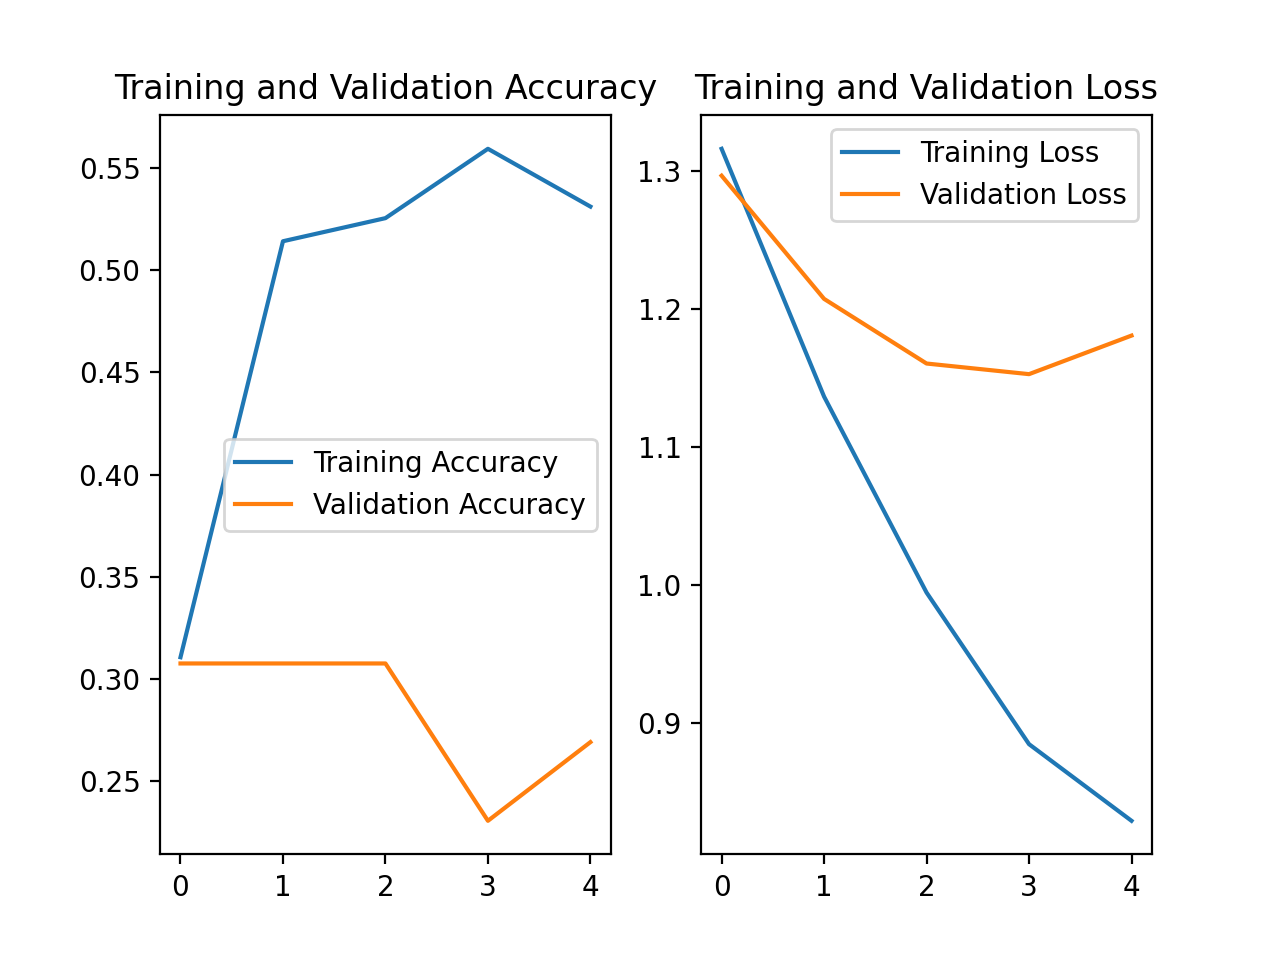

In [11]:
# 显示训练集和验证集的acc和loss曲线
plt.figure(1)
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
plt.savefig('CNN_Rice_Label_ACC_LOSS.png')

<IPython.core.display.Javascript object>


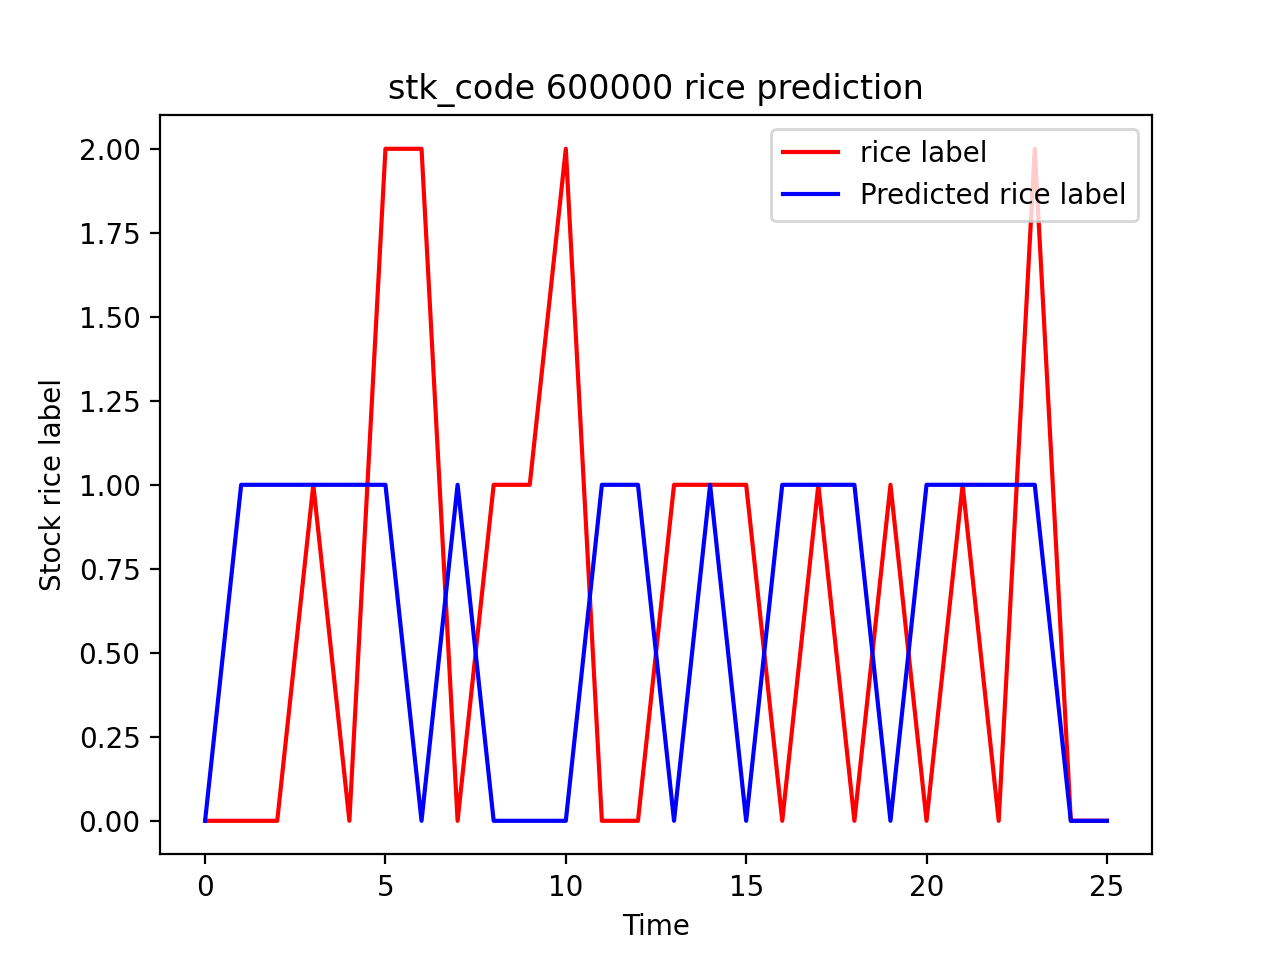

In [12]:
# 预测
# 测试集输入模型进行预测
plt.figure(2)
predicted_stock_rice = model.predict(x_test)
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_stock_rice = sc.inverse_transform(predicted_stock_rice)
pred = tf.argmax(predicted_stock_rice, axis=1)

real_stock_rice_label = test_label[sample_sz:]
# 画出真实数据和预测数据的对比曲线

plt.plot(real_stock_rice_label, color='red', label='rice label')
plt.plot(pred, color='blue', label='Predicted rice label')
plt.title('stk_code '+stock_code + ' rice prediction')
plt.xlabel('Time')
plt.ylabel('Stock rice label')
plt.legend()
plt.show()
plt.savefig('CNN_Rice_Label_Pridiction.png')